# <机器学习>课程 Lecture 2 实验

## 逻辑回归模型

给定一组数据,其输入维度为2,输出维度为1.完成二分类任务.

请分别使用sklearn,梯度下降法和模拟退火法来拟合.

从文件中读取数据用于后续实验.

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split

data_filename = "cls_data_0303_1007_2.npy"
cls_data = np.load(data_filename)
x_data, y_data = cls_data[:, :-1], cls_data[:, -1]

x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data,
    train_size=0.8, shuffle=True,
    stratify=y_data
)

# x_data in [b, c_in]
c_in = x_data.shape[1]
# y_data in [b, c_out]
c_out = 1


首先可视化数据,观察是否是可分的.

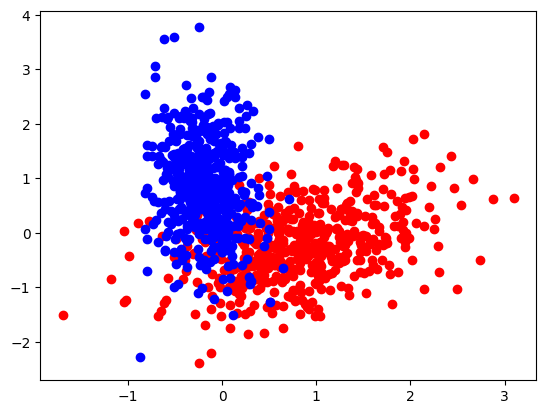

In [2]:
from matplotlib import pyplot as plt

plt.figure()

pos_data = x_data[y_data == 1, :]
neg_data = x_data[y_data == 0, :]

plt.scatter(pos_data[:, 0], pos_data[:, 1], c='red')
plt.scatter(neg_data[:, 0], neg_data[:, 1], c='blue')

plt.show()

### 使用sklearn中的线性模型拟合


In [37]:
from sklearn.linear_model import LogisticRegression

# === 创建模型并进行拟合 ===
model = LogisticRegression()
model.fit(x_train, y_train)

# === 计算模型的分类准确率 ===
accuracy = model.score(x_test, y_test)
print(accuracy)

0.93


### 参考之前线性模型实验的代码,实现梯度下降拟合

In [38]:
import numpy as np

# == 补全sigmoid定义 ===
def sigmoid(val: np.ndarray) -> np.ndarray:
    """ sigmoid function """
    return 1.0 / (1.0 + np.exp(-val))

class LogisticRegression():
    """
    logistic regression
    """
    def __init__(self,
        c_in: int, c_out: int,
        init_mean: float, init_var: float,
        bias: bool=True
    ) -> None:
        self.weight = np.random.normal(
            init_mean, init_var,
            size=(c_in, c_out)
        )
        if bias:
            self.bias = np.random.normal(
                init_mean, init_var,
                size=(1, c_out)
            )
        else:
            self.bias = None

    def predict(self,
        x: np.ndarray,
        weight: np.ndarray=None
    ) -> np.ndarray:
        if weight is None:
            weight = self.weight
        if self.bias is not None:
            return sigmoid(np.dot(x, weight) + self.bias)
        else:
            return sigmoid(np.dot(x, weight))

    def fit_gradient_descent(self, x: np.ndarray, y: np.ndarray, step: float=0.001, iteration: int=100) -> None:
        for _ in range(iteration):
            y_pred = self.predict(x)

            # 确保y是二维数组
            if y.ndim == 1:
                y = y.reshape(-1, 1)

            # 计算损失和梯度
            loss = y_pred - y  # 误差
            gradient = np.dot(x.T, loss) / x.shape[0]  # 平均梯度

            # 更新权重
            self.weight -= step * gradient

    def score(self, x: np.ndarray, y: np.ndarray) -> float:
        y_pred = self.predict(x)
        y_pred = np.round(y_pred)  # 将预测值四舍五入
        # 确保y是二维数组
        if y.ndim == 1:
            y = y.reshape(-1, 1)  # 将y变成二维数组
        return np.mean(y_pred == y)

In [44]:

# === 创建模型并进行拟合 ===
model = LogisticRegression(c_in, c_out = 800,init_mean=0.0, init_var=0.01)
model.fit_gradient_descent(x_train, y_train)

# === 计算模型的分类准确率 ===
accuracy = model.score(x_test, y_test)
print(accuracy)


0.88055


### 参考之前线性模型实验的代码,实现模拟退火法拟合

In [46]:
import numpy as np
from copy import deepcopy

class SimulatedAnnealing(object):
    def __init__(self,c_in, c_out, init_mean, init_val, bias) -> None:
        self.model = LogisticRegression(c_in, c_out, init_mean, init_val, bias)

    def nll_loss(self, logits, label):
        '''计算nll损失'''
        logits = logits[:, 0]
        loss = logits * label + (1-logits)*(1-label)
        return -np.log(loss.mean())

    def accuracy(self, logits, label):
        '''计算分类准确率'''
        label = label[:, np.newaxis]
        preds = np.where(logits > 0.5,
                         np.ones_like(logits),
                         np.zeros_like(logits))

        return np.array(preds == label, np.uint).mean()

    def fit(self, x, y, step=0.01, iterations=100, rounds=10, init_temp=1):
        # 首先使用给定的数据拟合
        self.model.fit_gradient_descent(x, y, step, iterations)

        # 初始化最优状态
        best_model = deepcopy(self.model)
        best_accu = self.accuracy(self.model.predict(x), y)
        best_loss = self.nll_loss(self.model.predict(x), y)
        print("init_accu = ", best_accu)
        print("init_loss = ", best_loss)

        temp = init_temp
        # 开始多轮迭代
        for round_idx in range(rounds):
            # 温度下降
            temp = temp * 0.9

            # 添加扰动更新权重
            perturb = np.random.normal(0, 0.1, size=self.model.weight.shape)
            cur_model = deepcopy(best_model)
            cur_model.weight += perturb
            cur_model.bias += np.random.normal(0, 0.1, size=cur_model.bias.shape)

            # 在新状态下拟合并计算新状态损失
            cur_loss = self.nll_loss(cur_model.predict(x), y)
            
            print(f"#{round_idx}/{rounds}, temp = {temp:3f} best_loss = {best_loss:.4f} cur_loss = {cur_loss:.4f},")
            
            # 确认是否更新
            if cur_loss < best_loss:
                best_model = deepcopy(cur_model)
                best_loss = cur_loss

model = SimulatedAnnealing(c_in, c_out, 0, 0.1, True)
model.fit(x_train, y_train, 0.01, 100, 10, 1)

print(model.accuracy(model.model.predict(x_train), y_train))
print(model.accuracy(model.model.predict(x_test), y_test))

init_accu =  0.85875
init_loss =  0.6102125782788548
#0/10, temp = 0.900000 best_loss = 0.6102 cur_loss = 0.5766,
#1/10, temp = 0.810000 best_loss = 0.5766 cur_loss = 0.5809,
#2/10, temp = 0.729000 best_loss = 0.5766 cur_loss = 0.5763,
#3/10, temp = 0.656100 best_loss = 0.5763 cur_loss = 0.5184,
#4/10, temp = 0.590490 best_loss = 0.5184 cur_loss = 0.5094,
#5/10, temp = 0.531441 best_loss = 0.5094 cur_loss = 0.5074,
#6/10, temp = 0.478297 best_loss = 0.5074 cur_loss = 0.5313,
#7/10, temp = 0.430467 best_loss = 0.5074 cur_loss = 0.5262,
#8/10, temp = 0.387420 best_loss = 0.5074 cur_loss = 0.5053,
#9/10, temp = 0.348678 best_loss = 0.5053 cur_loss = 0.5066,
0.85875
0.875
